<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#NIRCam-Imaging-test" data-toc-modified-id="NIRCam-Imaging-test-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>NIRCam Imaging test</a></span><ul class="toc-item"><li><span><a href="#Disk-usage" data-toc-modified-id="Disk-usage-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Disk usage</a></span></li><li><span><a href="#Run-jwst-pipeline-un-uncalibrated-simulations" data-toc-modified-id="Run-jwst-pipeline-un-uncalibrated-simulations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Run <code>jwst</code> pipeline un <code>uncal</code>ibrated simulations</a></span></li><li><span><a href="#Fetch-cal-files-from-AWS-bucket" data-toc-modified-id="Fetch-cal-files-from-AWS-bucket-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Fetch <code>cal</code> files from AWS bucket</a></span></li></ul></li><li><span><a href="#Astrometric-alignment" data-toc-modified-id="Astrometric-alignment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Astrometric alignment</a></span></li><li><span><a href="#Parse-Visits" data-toc-modified-id="Parse-Visits-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parse Visits</a></span></li><li><span><a href="#Run-the-preprocessing-scripts" data-toc-modified-id="Run-the-preprocessing-scripts-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run the preprocessing scripts</a></span></li><li><span><a href="#Aside:-Drizzle-and-Drizzlepac" data-toc-modified-id="Aside:-Drizzle-and-Drizzlepac-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Aside: <code>Drizzle</code> and <code>Drizzlepac</code></a></span><ul class="toc-item"><li><span><a href="#Derived-SIP-WCS-headers" data-toc-modified-id="Derived-SIP-WCS-headers-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Derived SIP WCS headers</a></span></li><li><span><a href="#Check-the-function-jwst_utils.compare_gwcs_sip-that-maps-the-modified-SIP-WCS-back-to-the-gwcs-keywords" data-toc-modified-id="Check-the-function-jwst_utils.compare_gwcs_sip-that-maps-the-modified-SIP-WCS-back-to-the-gwcs-keywords-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Check the function <code>jwst_utils.compare_gwcs_sip</code> that maps the modified SIP WCS back to the <code>gwcs</code> keywords</a></span></li></ul></li><li><span><a href="#Drizzle-full-mosaics" data-toc-modified-id="Drizzle-full-mosaics-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Drizzle full mosaics</a></span><ul class="toc-item"><li><span><a href="#RGB-mosaic" data-toc-modified-id="RGB-mosaic-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>RGB mosaic</a></span></li></ul></li><li><span><a href="#Multiwavelength-catalog" data-toc-modified-id="Multiwavelength-catalog-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Multiwavelength catalog</a></span><ul class="toc-item"><li><span><a href="#Catalog-detection-image" data-toc-modified-id="Catalog-detection-image-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Catalog detection image</a></span></li><li><span><a href="#Source-detection-and-aperture-photometry" data-toc-modified-id="Source-detection-and-aperture-photometry-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Source detection and aperture photometry</a></span></li><li><span><a href="#Compare-to-input-photometry-from-the-simulation" data-toc-modified-id="Compare-to-input-photometry-from-the-simulation-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Compare to input photometry from the simulation</a></span><ul class="toc-item"><li><span><a href="#Completeness" data-toc-modified-id="Completeness-7.3.1"><span class="toc-item-num">7.3.1&nbsp;&nbsp;</span>Completeness</a></span></li></ul></li></ul></li><li><span><a href="#TBD" data-toc-modified-id="TBD-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>TBD</a></span></li></ul></div>

# NIRCam Imaging test 

Simulations by the CEERS team from https://ceers.github.io/sdr1.html

Here we use the full NIRCam simulations in "part2": https://web.corral.tacc.utexas.edu/ceersdata/SDR1/NIRCam/imaging/part2.tar.gz.  You don't need to download that full archive if you want to use the `cal.fits` files derived from them as demonstrated below.

Here we use the full `grizli` processing machinery to process a directory full of `cal.fits` exposures

## Disk usage

The subset of images used below requires 3.3 Gb of storage for the processed files and copies of the input exposures that are kept, and an additional 800 Mb for the big input catalog used by CEERS for the simulation.

In [1]:
import os
import glob
import logging

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import astropy.wcs as pywcs

import jwst

import grizli
from grizli import utils, prep, jwst_utils, multifit
from grizli.pipeline import auto_script

print('Grizli version: ', grizli.__version__)
print('jwst pipeline version: ', jwst.__version__)

# Quiet JWST log warnings
jwst_utils.QUIET_LEVEL = logging.WARNING
jwst_utils.set_quiet_logging(jwst_utils.QUIET_LEVEL)

Grizli version:  1.4.0.dev294
jwst pipeline version:  1.5.2


In [2]:
# Working directory, unpacked from "part2.tar.gz" downloaded from CEERS.  Can be anywhere
HOME_PATH = '/Volumes/CharmCity/JWST/Ceers/part2/'
os.chdir(HOME_PATH)

# Some directories needed for grizli
for dir in ['RAW','Prep']:
    if not os.path.exists(dir):
        print(f'mkdir {dir}')
        os.mkdir(dir)

In [3]:
# Local directory for CRDS, which can download lots of large files when doing the calibration
# can be anywhere...
os.environ['CRDS_PATH'] = '/Volumes/CharmCity/JWST/Ceers/CRDS_CEERS'

# CRDS Context preferred in CEERS notebooks
os.environ['CRDS_CONTEXT'] = 'jwst_0764.pmap'

## Run `jwst` pipeline un `uncal`ibrated simulations

Here don't bother so much with customizing the pipeline steps.  

TBD if we'll need to do this in practice or if we can just use the `cal.fits` files downloaded
directly from the archive.

**Alternative:** Skip to the next step below to pull some precomputed `cal.fits` files from AWS

In [4]:
import crds
from jwst.pipeline import Detector1Pipeline, Image2Pipeline

# First try returned some errors with the reference files
# provided in the specified CRDS_CONTEXT
crds.config.ALLOW_BAD_REFERENCES.set(True)
crds.config.ALLOW_BAD_REFERENCES.set(True)

files = glob.glob('uncals/*uncal.fits')
files.sort()

# Favor the AWS files below.  Reset the switch to process the CEERS uncals 
if False:
    
    for file in files:
        cal = file.replace('_uncal.fits','_cal.fits').replace('uncals/','RAW/')
        if len(glob.glob(cal+'*')) > 0:
            print(f'Skip {file}')
            continue
        else:
            print(f'Run {file}')

        print('  det1')
        det1 = Detector1Pipeline().run(file)

        print('  img2')
        img2, = Image2Pipeline().run(det1)

        det1.write(file.replace('_uncal.fits', '_rate.fits').replace('uncals/','RAW/'))

        cal_file = file.replace('_uncal.fits', '_cal.fits').replace('uncals/','RAW/')
        img2.write(cal_file)

        del(det1)
        del(img2)

        # Set TARGNAME keyword
        with pyfits.open(cal_file, mode='update') as im:
            im[0].header['TARGNAME'] = 'CEERS5'
            im.flush()

else:
    print('Nothing done, you probably need to do the next step below')

Nothing done, you probably need to do the next step below


## Fetch `cal` files from AWS bucket

Assuming you have the awscli installed and configured. 

The data files are in a `public-read` bucket and shouldn't generate any costs to fetch them.


In [5]:
os.chdir(HOME_PATH)
os.system('aws s3 sync s3://grizli-v2/JWST-Simulations/NIRCam-Imaging/CEERS/RAW/ ./RAW/')

# These files are gzipped, but files in RAW can be gzipped ('.gz') or not

0

In [6]:
os.chdir(HOME_PATH)

! ls RAW/* | head -40

RAW/jw01345005001_01101_00001_nrca1_cal.fits.gz
RAW/jw01345005001_01101_00001_nrca1_rate.fits
RAW/jw01345005001_01101_00001_nrca2_cal.fits.gz
RAW/jw01345005001_01101_00001_nrca2_rate.fits
RAW/jw01345005001_01101_00001_nrca3_cal.fits.gz
RAW/jw01345005001_01101_00001_nrca3_rate.fits
RAW/jw01345005001_01101_00001_nrca4_cal.fits.gz
RAW/jw01345005001_01101_00001_nrca4_rate.fits
RAW/jw01345005001_01101_00001_nrca5_cal.fits.gz
RAW/jw01345005001_01101_00001_nrca5_rate.fits
RAW/jw01345005001_01101_00001_nrcb1_cal.fits.gz
RAW/jw01345005001_01101_00001_nrcb1_rate.fits
RAW/jw01345005001_01101_00001_nrcb2_cal.fits.gz
RAW/jw01345005001_01101_00001_nrcb2_rate.fits
RAW/jw01345005001_01101_00001_nrcb3_cal.fits.gz
RAW/jw01345005001_01101_00001_nrcb3_rate.fits
RAW/jw01345005001_01101_00001_nrcb4_cal.fits.gz
RAW/jw01345005001_01101_00001_nrcb4_rate.fits
RAW/jw01345005001_01101_00001_nrcb5_cal.fits.gz
RAW/jw01345005001_01101_00001_nrcb5_rate.fits
RAW/jw01345005002_01101_00002_nrca1_cal.fits.gz
RAW/jw013450

# Astrometric alignment

Here align to sky positions in the CEERS catalog itself, since the alignment to the external reference won't work here because the sources have arbitrary positions.  We'll add a small offset to them to give the alignment script something non-trivial to find.

`master_radec` can be used with real data as well if you want to manually specify the sources used for the global astrometric alignment.  

The alignment file can just be an ASCII file with columns of ``ra`` and ``dec``, or a table with at least those columns.

In [7]:
os.chdir(HOME_PATH)

ceers_cat = 'ceers5_f200w_cat.ecsv'
if not os.path.exists(ceers_cat):
    os.system('wget "https://web.corral.tacc.utexas.edu/ceersdata/SDR1/NIRCam/imaging/mosaics/ceers5_f200w_cat.ecsv"')

cat = utils.read_catalog(ceers_cat, format='ascii.ecsv')

cat['ra'] = cat['sky_centroid'].ra.deg
cat['dec'] = cat['sky_centroid'].dec.deg

# Offset the *catalog* a bit to see that the alignment scripts can identify 
# slight shifts of the absolute astrometry in the files from the archive
dx_cat, dy_cat = 1., 0.5 # arcsec

cat['ra'] += dx_cat/3600/np.cos(cat['dec']/180*np.pi)
cat['dec'] += dy_cat/3600.

# Good to not have *too many* sources in the alignment catalog as the 
# pair-finding algorithm is really slow when matching catalogs with more than ~200 sources. 
# That doesn't necessarily mean <200 sources in the parent alignment catalog, but rather 
# <200 sources in the subset that could be used to align a given exposure

ok = cat['isophotal_abmag'] < 23
print('Number of alignment sources: ', ok.sum())

# Write files
prep.table_to_regions(cat[ok], 'ceers5.reg') # DS9 regions
prep.table_to_radec(cat[ok], 'ceers5.radec') # simple ra/dec table


Number of alignment sources:  419
ceers5.reg: x = ra, y=dec, ellipse=False


In [8]:
# Exposure summary table, just to see what files are available
os.chdir(HOME_PATH + '/Prep')

files = glob.glob('../RAW/*cal.fits*')
files.sort()

info = utils.get_flt_info(files=files)
info

<Table length=90>
                  FILE                      FILTER   ... POSTARG1 POSTARG2
                 str40                      str11    ... float64  float64 
---------------------------------------- ----------- ... -------- --------
jw01345005001_01101_00001_nrca1_cal.fits F115W-CLEAR ...      nan      nan
jw01345005001_01101_00001_nrca2_cal.fits F115W-CLEAR ...      nan      nan
jw01345005001_01101_00001_nrca3_cal.fits F115W-CLEAR ...      nan      nan
jw01345005001_01101_00001_nrca4_cal.fits F115W-CLEAR ...      nan      nan
jw01345005001_01101_00001_nrca5_cal.fits F277W-CLEAR ...      nan      nan
                                     ...         ... ...      ...      ...
jw01345005009_01101_00009_nrca5_cal.fits F444W-CLEAR ...      nan      nan
jw01345005009_01101_00009_nrcb1_cal.fits F200W-CLEAR ...      nan      nan
jw01345005009_01101_00009_nrcb2_cal.fits F200W-CLEAR ...      nan      nan
jw01345005009_01101_00009_nrcb3_cal.fits F200W-CLEAR ...      nan      nan
jw01345005009_01101_00009_nrcb4_cal.fits F200W-CLEAR ...      nan      nan
jw01345005009_01101_00009_nrcb5_cal.fits F444W-CLEAR ...      nan      nan

# Parse Visits

Group exposures in a given filter / detector into separate "visits", which will be processed separately. 

Basically, when working in the `Prep` directory, the script will try to parse "visit" associations for any `cal` or `rate` exposures found in `../RAW`.

The visit association parser splits exposures into separate groups that are separated by more than `visit_split_shift` arcminutes, i.e., exposures that won't overlap for "tweakshifts" alignment.  For NIRCam this naturally splits exposures from the different modules / detectors into separate visits, which we want because they won't overlap enough for the grizli "tweakshifts" alignment to work between them.

The visit names are named based on the `OBJECT` header keyword, which are "UNKNOWN" for the MIRAGE simulations....

In [9]:
os.chdir(HOME_PATH + '/Prep')

# This rootname used throughout
root='ceers5'

# For starters, limit to one SW detector and LW of module A. 
# If `files` not specified, will find everyting in `RAW_PATH`
files = glob.glob('../RAW/*nrca1_cal.fits*')
files += glob.glob('../RAW/*nrca5_cal.fits*')

# Just one filter for even faster test
if False:
    files = glob.glob('../RAW/*nrca5_cal.fits*')
    files.sort()
    files = files[:3]
    
files.sort()

visits, all_groups, info = auto_script.parse_visits(field_root=root,
                                                    visit_split_shift=1.2, # This separates NRC SW
                                                    files=files, 
                                                    combine_same_pa=False,
                                                    RAW_PATH='../RAW')

# (2022-06-10 15:23:47.683)

auto_script.parse_visits(**{'files': ['../RAW/jw01345005001_01101_00001_nrca1_cal.fits.gz', '../RAW/jw01345005001_01101_00001_nrca5_cal.fits.gz', '../RAW/jw01345005002_01101_00002_nrca1_cal.fits.gz', '../RAW/jw01345005002_01101_00002_nrca5_cal.fits.gz', '../RAW/jw01345005003_01101_00003_nrca1_cal.fits.gz', '../RAW/jw01345005003_01101_00003_nrca5_cal.fits.gz', '../RAW/jw01345005004_01101_00004_nrca1_cal.fits.gz', '../RAW/jw01345005004_01101_00004_nrca5_cal.fits.gz', '../RAW/jw01345005005_01101_00005_nrca1_cal.fits.gz', '../RAW/jw01345005005_01101_00005_nrca5_cal.fits.gz', '../RAW/jw01345005006_01101_00006_nrca1_cal.fits.gz', '../RAW/jw01345005006_01101_00006_nrca5_cal.fits.gz', '../RAW/jw01345005007_01101_00007_nrca1_cal.fits.gz', '../RAW/jw01345005007_01101_00007_nrca5_cal.fits.gz', '../RAW/jw01345005008_01101_00008_nrca1_cal.fits.gz', '../RAW/jw01345005008_01101_00008_nrca5_cal.fits.gz', '../RAW/jw01345005009_01101_00009_nrca1_cal.fits.gz', '../RAW/jw01345

In [10]:
! cat ceers5_visits.yaml

groups: []
info:
  DATE-OBS:
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  - '2022-06-16'
  DEC_TARG:
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  - 52.90442
  DETECTOR:
  - NRCA1
  - NRCALONG
  - NRCA1
  - NRCALONG
  - NRCA1
  - NRCALONG
  - NRCA1
  - NRCALONG
  - NRCA1
  - NRCALONG
  - NRCA1
  - NRCALONG
  - NRCA1
  - NRCALONG
  - NRCA1
  - NRCALONG
  - NRCA1
  - NRCALONG
  EXPSTART:
  - 59746.08999533565
  - 59746.08999533565
  - 59746.10911806713
  - 59746.10911806713
  - 59746.12824078704
  - 59746.12824078704
  - 59746.14736351852
  - 59746.14736351852
  - 59746.16

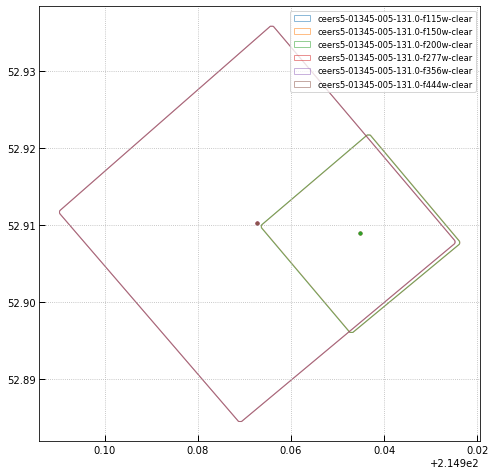

In [12]:
# Preview what will be processed
colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]

fig, ax = plt.subplots(1,1,figsize=(8,8))

for i, v in enumerate(visits):
    sr = utils.SRegion(v['footprint'])

    ax.scatter(*sr.centroid[0], marker='.', c=colors[i])
    
    for patch in sr.patch(ec=colors[i], fc='None', alpha=0.5, label=v['product']):
        ax.add_patch(patch)

ax.set_aspect(1./np.cos(ax.get_ylim()[0]/180*np.pi)) # square with cos(dec)
ax.set_xlim(ax.get_xlim()[::-1])
ax.legend()
ax.grid()

# Run the preprocessing scripts

The processing does the following:

1. CR rejection
2. Simple shifts alignment between exposures
3. Global astrometry w.r.t some reference
 - Here the scripts find reference sources in the LegacySurveys DR9 catalog
 - The reddest bands are processed first, here F444W, and the first is aligned
   to the external reference
 - Then for subsequent "visits", i.e., the separate SW detector images for F150W, 
   the (globally aligned) *F444W* image itself will be used as the astrometric reference
4. Final background subtraction with a SourceExtractor-like median background

In [13]:
# preprocessing parameters
from grizli.pipeline.auto_script import get_yml_parameters

# Read the default parameters that can be edited and passed en-masse to `auto_script.go`
kwargs = get_yml_parameters()

# Parameter lists
visit_prep_args = kwargs['visit_prep_args']
preprocess_args = kwargs['preprocess_args']

# Maximum shift for "tweakshifts" relative alignment
visit_prep_args['tweak_max_dist'] = 1.

# Will fit and subtract a SExtractor-like background to each visit
# filter size is bh x pixel_scale arcsec, which is then interpreted
# at the pixel scale of each intrument
visit_prep_args['imaging_bkg_params']  = {'bh': 256, 'bw': 256, 'fh': 3, 'fw': 3, 
                                          'pixel_scale': 0.1, 'get_median': False}

# External alignment reference catalogs, searched in this order
# LS_DR9 is a good option for fairly high source density and sky coverage, deeper than PS1
# GAIA preferred of course, but source density isn't usually very high for 
# extragalactic fields
visit_prep_args['reference_catalogs'] = ['LS_DR9', 'PS1','GAIA','SDSS','WISE']

# Use the alignment catalog we made earlier, which will supercede `reference_catalogs`
preprocess_args['master_radec'] = os.path.join(HOME_PATH, 'ceers5.radec') # (with absolute path)

In [14]:
im = pyfits.open(glob.glob('../RAW/*_cal.fits*')[0])

# Use the CONTEXT that was used when making the calibrated images above
# THis isn't used for much here, but sets the geometric distortion / WCS
print('CRDS_CONTEXT: ', im[0].header['CRDS_CTX'])

os.environ['CRDS_CONTEXT'] = im[0].header['CRDS_CTX']

CRDS_CONTEXT:  jwst_0764.pmap


In [16]:
print(os.getcwd())
! ls

/Volumes/CharmCity/JWST/Ceers/part2/Prep
ceers5_visits.yaml


In [18]:
os.chdir(os.path.join(HOME_PATH, 'Prep'))

# This script will do all the preprocessing of all grism and imaging visits 
# found earlier
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH,
                       visit_prep_args=visit_prep_args, **preprocess_args)   

# (2022-06-10 15:37:03.259)

auto_script.preprocess(**{'field_root': 'ceers5', 'HOME_PATH': '/Volumes/CharmCity/JWST/Ceers/part2/', 'PERSIST_PATH': None, 'min_overlap': 0.2, 'make_combined': False, 'catalogs': ['PS1', 'DES', 'NSC', 'SDSS', 'GAIA', 'WISE'], 'use_visit': True, 'master_radec': '/Volumes/CharmCity/JWST/Ceers/part2/ceers5.radec', 'parent_radec': None, 'use_first_radec': False, 'skip_imaging': False, 'clean': True, 'skip_single_optical_visits': False, 'visit_prep_args': {'align_thresh': None, 'align_rms_limit': 2, 'align_mag_limits': [14, 24, 0.05], 'align_assume_close': False, 'align_transform': None, 'align_ref_border': 100, 'max_err_percentile': 99, 'align_min_flux_radius': 1.0, 'catalog_mask_pad': 0.05, 'match_catalog_density': False, 'drizzle_params': {}, 'single_image_CRs': True, 'run_tweak_align': True, 'tweak_threshold': 1.5, 'tweak_fit_order': -1, 'tweak_max_dist': 1.0, 'tweak_n_min': 10, 'align_simple': False, 'align_clip': 120, 'column_average': True, 'sky_iter': 

In [19]:
# Update the visits file with the new exposure footprints
visit_file = auto_script.find_visit_file(root=root)
print('Update exposure footprints in {0}'.format(visit_file))
_ = auto_script.get_visit_exposure_footprints(root=root, check_paths=['./'])

Update exposure footprints in ./ceers5_visits.yaml


In [20]:
# Tweakshifts
! cat *shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['jw01345005001_01101_00001_nrca1_cal.fits'] = []
# match['jw01345005002_01101_00002_nrca1_cal.fits'] = []
# match['jw01345005003_01101_00003_nrca1_cal.fits'] = []
jw01345005001_01101_00001_nrca1_cal.fits   0.000   0.000  0.00000  1.00000   100  0.000  0.000
jw01345005002_01101_00002_nrca1_cal.fits   0.033  -0.105  0.00000  1.00000    84  0.061  0.088
jw01345005003_01101_00003_nrca1_cal.fits  -0.005  -0.039  0.00000  1.00000    82  0.046  0.077
# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['jw01345005004_01101_00004_nrca1_cal.fits'] = []
# match['jw01345005005_01101_00005_nrca1_cal.fits'] = []
# match['jw01345005006_01101_00006_nrca1_cal.fits'] = []
jw01345005004_01101_00004_nrca1_cal.fits   0.000  -0.000  0.00000  1.00000   100  0.000  0.000
jw01345005005_01101_00005_nrca1_cal.fits   0.124  -0.096  0.00000  1.00000    87  0.066  0.079
jw01345005006_01101_00006_nrca1_cal.fits   0.113   0.038  0.00000  

In [21]:
# Global alignment.
# These derived shifts are non-zero because we shifted the reference catalog above
! cat *wcs.log

# ext xshift yshift rot scale rms N
# radec: /Volumes/CharmCity/JWST/Ceers/part2/ceers5.radec
# ceers5-01345-005-131.0-f115w-clear
    0      -33.1039      -14.0150       -0.0006       1.00000         0.101   32
# ext xshift yshift rot scale rms N
# radec: /Volumes/CharmCity/JWST/Ceers/part2/ceers5.radec
# ceers5-01345-005-131.0-f150w-clear
    0      -33.0675      -14.1510        0.0015       1.00000         0.065   32
# ext xshift yshift rot scale rms N
# radec: /Volumes/CharmCity/JWST/Ceers/part2/ceers5.radec
# ceers5-01345-005-131.0-f200w-clear
    0      -30.2344      -10.0083       -0.0021       1.00000         0.070   27
# ext xshift yshift rot scale rms N
# radec: /Volumes/CharmCity/JWST/Ceers/part2/ceers5.radec
# ceers5-01345-005-131.0-f277w-clear
    0      -16.4689       -6.9550       -0.0000       1.00000         0.067  113
# ext xshift yshift rot scale rms N
# radec: /Volumes/CharmCity/JWST/Ceers/part2/ceers5.radec
# ceers5-01345-005-131.0-f356w-clear
    0      -15.7560  

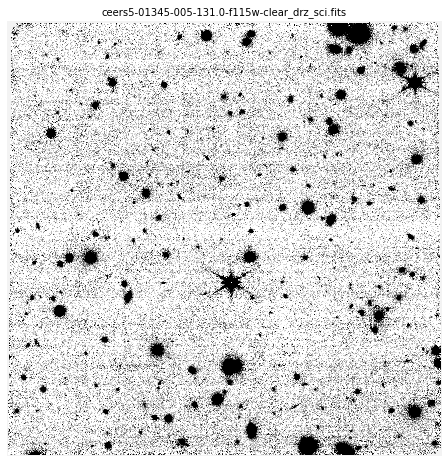

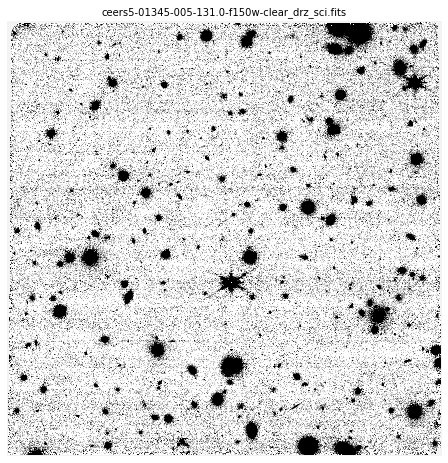

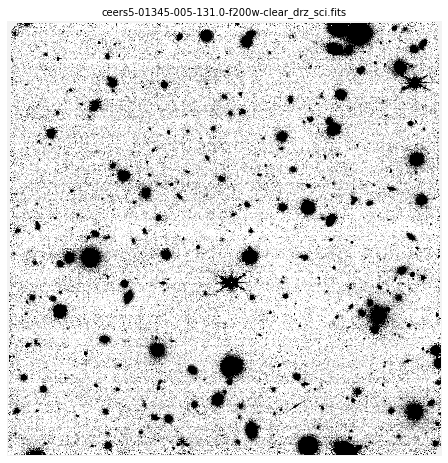

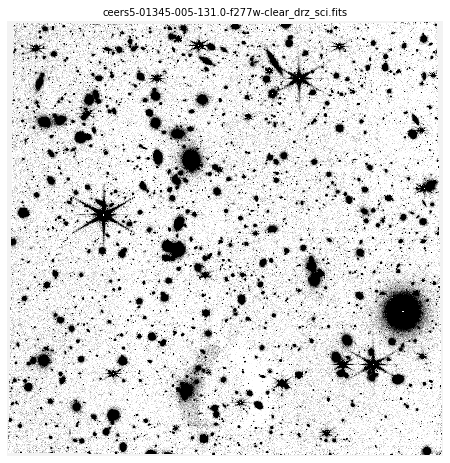

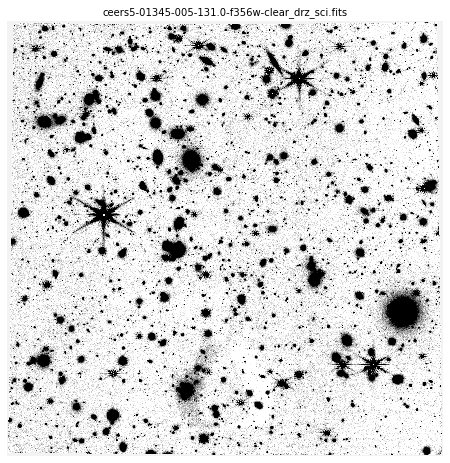

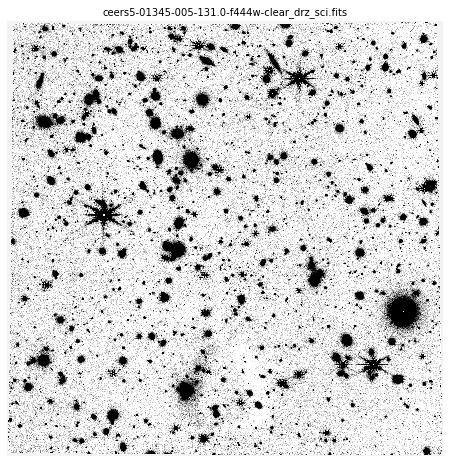

In [22]:
# Show "visit" images
import matplotlib.pyplot as plt

files = glob.glob('*sci.fits')
for file in files:
    im = pyfits.open(file)
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    vm = np.nanpercentile(im[0].data, [5, 90])
    ax.imshow(im[0].data, vmin=-0.1*vm[1], vmax=2*vm[1], cmap='gray_r')
    ax.set_aspect(1)
    ax.set_title(file)
    ax.axis('off')

# Aside: `Drizzle` and `Drizzlepac`

Note: grizli uses classic `drizzle` / `AstroDrizzle` for the image combination and resampling!  It has lots of various helper scripts to use drizzle in different ways to make aligned images and the new `resample` steps in the `JWST` pipeline aren't mature enough to trust.  Furthermore, they don't work with HST.  

In order to use `AstroDrizzle` with JWST exposures, we need to modify some header keywords to make `AstroDrizzle` think that the FITS files came from HST (e.g., WFC3/IR).  We also have to translate the new JWST `gwcs` WCS into a SIP-formatted header.  While there is a built-in function in `gwcs` to do this (`gwcs.to_fits_sip`), that function doesn't seem to return a mapping with the desired precision.  The low presision isn't a function of the distortion model itself, and there are now internal grizli scripts to do this that return SIP headers that are consistent with the `gwcs` WCS at precision < 0.001 pixels.  

The various grizli astrometric alignment procedures in the pipeline update the SIP FITS header and currently don't propagate the alignment back to the `gwcs`, though there is a draft function to do this (`grizli.jwst_utils.match_gwcs_to_sip`).

## Derived SIP WCS headers

The steps below demonstrate the functions that derive the SIP approximations to the `gwcs` WCS stored in, e.g., `datamodel.meta.wcs`.

In [44]:
# Temporary directory
os.chdir(os.path.join(HOME_PATH, 'Prep'))

files = glob.glob('*a5_cal.fits')
files.sort()
file = files[0]

if not os.path.exists('../CompareWCS'):
    os.mkdir('../CompareWCS')

os.chdir('../CompareWCS')
os.system(f'cp ../RAW/{file}.gz .')
os.system(f'gunzip --force {file}.gz')

0

OTELESCO = TELESCOP JWST
OINSTRUM = INSTRUME NIRCAM
ODETECTO = DETECTOR NRCALONG
OFILTER = FILTER F277W
OPUPIL = PUPIL CLEAR
OEXP_TYP = EXP_TYPE NRC_IMAGE


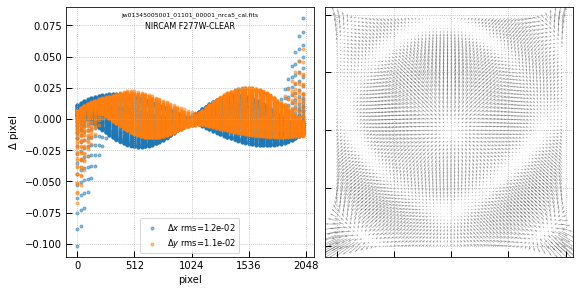

In [45]:
# First example is the SIP wcs in the `cal` file produced by Image2
# Not very good, pixel residuals ~0.02 pix.

# (The messages that go by show header keywords that are copied because
#  they could be changed later to make the exposures look like WFC3)
_ = jwst_utils.compare_gwcs_sip(file, use_gwcs_func=False, save=False)

OTELESCO = TELESCOP JWST
OINSTRUM = INSTRUME NIRCAM
ODETECTO = DETECTOR NRCALONG
OFILTER = FILTER F277W
OPUPIL = PUPIL CLEAR
OEXP_TYP = EXP_TYPE NRC_IMAGE


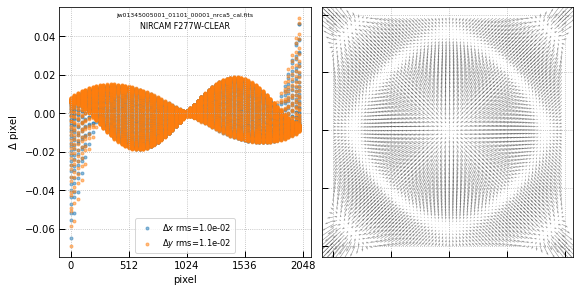

In [46]:
# Show what you'd get with meta.wcs.to_fits_sip
# - this is pretty much what we had before, still not so good
#   and decreasing `max_pix_error` doesn't help
_ = jwst_utils.compare_gwcs_sip(file, save=False,
                                use_gwcs_func=True, 
                                func_kwargs={'degree': 5,
                                             'crpix': [1024.5, 1024.5],
                                             'max_pix_error': 0.001})

OTELESCO = TELESCOP JWST
OINSTRUM = INSTRUME NIRCAM
ODETECTO = DETECTOR NRCALONG
OFILTER = FILTER F277W
OPUPIL = PUPIL CLEAR
OEXP_TYP = EXP_TYPE NRC_IMAGE
# (2022-06-10 15:40:54.391)

jwst_utils.pipeline_model_wcs_header(**{'datamodel': <ImageModel(2048, 2048) from jw01345005001_01101_00001_nrca5_cal.fits>, 'step': 64, 'degrees': [3, 4, 5, 5], 'lsq_args': {'jac': '2-point', 'bounds': (-inf, inf), 'method': 'trf', 'ftol': 1e-12, 'xtol': 1e-12, 'gtol': 1e-12, 'x_scale': 1.0, 'loss': 'soft_l1', 'f_scale': 1000.0, 'diff_step': 1e-06, 'tr_solver': None, 'tr_options': {}, 'jac_sparsity': None, 'max_nfev': 100, 'verbose': 0, 'kwargs': {}}, 'crpix': None, 'verbose': True, 'initial_header': None, 'max_rms': 0.0001, 'set_diff_step': False, 'get_guess': False, 'fast_coeffs': True})

Fit SIP degree=3 rms= 8.49e-03, 8.51e-03 pix
Fit SIP degree=4 rms= 7.44e-03, 8.04e-03 pix
Fit SIP degree=5 rms= 4.58e-04, 4.57e-04 pix
Fit SIP degree=5 rms= 4.58e-04, 4.57e-04 pix


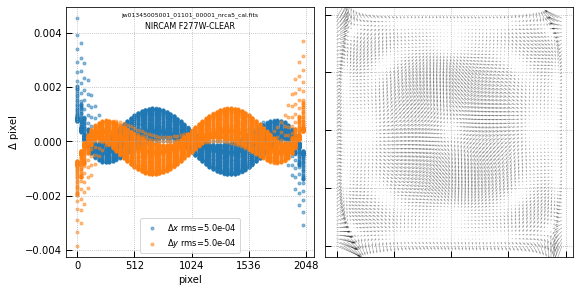

In [47]:
# This function regenerates the gwcs object (dm.meta.wcs), 
# derives the SIP approximation and overwrites the SIP
# header keywords in the file
# 
# Not quite clear why this algorithm works better than `to_fits_sip`, though the algorithm here 
# differs from that in that it
# 
# 1) Fits for the polynomial SIP coefficients directly rather than doing the math 
#    analytically decomposing the polynomial coefficients into the CD matrix and SIP 
#    parameters.
#
# 2) Allows for small shifts of CRVAL and rotation / scaling of the CD matrix
#
dm = jwst_utils.img_with_wcs(file)

# Run the comparison again: now the RMS residual between the transforms is < 0.001 pix
_ = jwst_utils.compare_gwcs_sip(file, use_gwcs_func=False, save=False)

In [48]:
# The pipeline_model_wcs_header function tries increasing degrees of the 
# SIP polynomial until a target precision is reached
sip_header = jwst_utils.pipeline_model_wcs_header(dm, step=32, degrees=[3,4,5,5], 
                                                  fast_coeffs=True, crpix=None, 
                                                  max_rms=1.e-4)

# Here's the function that actually derives the SIP coefficients
sip_header = jwst_utils.model_wcs_header(dm, get_sip=True, degree=5, 
                                         fit_crval=True, fit_rot=True, fit_scale=True, 
                                         step=32, crpix=[1024.5, 1024.5], 
                                         set_diff_step=False, 
                                         fast_coeffs=True, 
                                         get_guess=False)

print('\n Pixel residual RMS')
for k in ['SIPRAMAD', 'SIPDEMAD', 'SIPCOST']:
    print(f'{k}: {sip_header[k]:.2e}')

# (2022-06-10 15:40:58.858)

jwst_utils.pipeline_model_wcs_header(**{'datamodel': <ImageModel(2048, 2048) from jw01345005001_01101_00001_nrca5_cal.fits>, 'step': 32, 'degrees': [3, 4, 5, 5], 'lsq_args': {'jac': '2-point', 'bounds': (-inf, inf), 'method': 'trf', 'ftol': 1e-12, 'xtol': 1e-12, 'gtol': 1e-12, 'x_scale': 1.0, 'loss': 'soft_l1', 'f_scale': 1000.0, 'diff_step': 1e-06, 'tr_solver': None, 'tr_options': {}, 'jac_sparsity': None, 'max_nfev': 100, 'verbose': 0, 'kwargs': {}}, 'crpix': None, 'verbose': True, 'initial_header': None, 'max_rms': 0.0001, 'set_diff_step': False, 'get_guess': False, 'fast_coeffs': True})

Fit SIP degree=3 rms= 9.23e-03, 9.25e-03 pix
Fit SIP degree=4 rms= 8.18e-03, 8.75e-03 pix
Fit SIP degree=5 rms= 4.90e-04, 4.88e-04 pix
Fit SIP degree=5 rms= 4.90e-04, 4.89e-04 pix

 Pixel residual RMS
SIPRAMAD: 4.90e-04
SIPDEMAD: 4.89e-04
SIPCOST: 1.04e-03


In [49]:
# Show the header
sip_header

RADESYS = 'ICRS    '                                                            
CTYPE1  = 'RA---TAN-SIP'                                                        
CTYPE2  = 'DEC--TAN-SIP'                                                        
CUNIT1  = 'deg     '                                                            
CUNIT2  = 'deg     '                                                            
CRPIX1  =               1024.5                                                  
CRPIX2  =               1024.5                                                  
CRVAL1  =    214.9674178950152                                                  
CRVAL2  =    52.90992212777706                                                  
CD1_1   = 1.13169697789610E-05                                                  
CD1_2   = 1.33136758182065E-05                                                  
CD2_1   = 1.32669294770357E-05                                                  
CD2_2   = -1.1390159957994E-

In [50]:
# A final comment in that it's not quite clear why we don't get an even better match, 
# since the `gwcs` transformation is itself a polynomial and the residuals look like 
# polynomials of order less than that of the SIP fit

# Do the small filter offsets help? Not really
tf = dm.meta.wcs.pipeline[0].transform

sip_header = jwst_utils.model_wcs_header(dm, get_sip=True, degree=5, 
                                         fit_crval=True, fit_rot=True, fit_scale=True, 
                                         step=16,
                                         crpix=[1024.5 - tf.offset_0, 1024.5 - tf.offset_1], 
                                         set_diff_step=False, 
                                         fast_coeffs=True, 
                                         get_guess=False, 
                                         initial_header=sip_header)

print('Pixel residual RMS')
for k in ['SIPRAMAD', 'SIPDEMAD', 'SIPCOST']:
    print(f'{k}: {sip_header[k]:.2e}')

Pixel residual RMS
SIPRAMAD: 4.81e-04
SIPDEMAD: 4.81e-04
SIPCOST: 4.22e-03


## Check the function `jwst_utils.compare_gwcs_sip` that maps the modified SIP WCS back to the `gwcs` keywords

Do the check on the exposures in ``Prep`` where the WCS keywords were modified in the astrometric alignment pipeline.

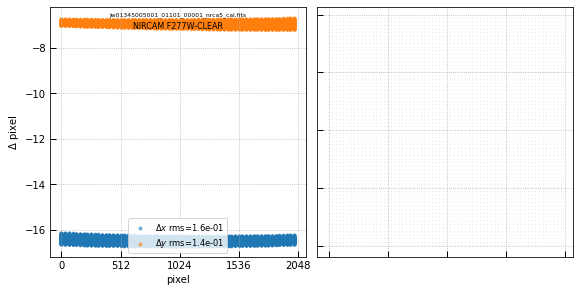

In [51]:
# Get the realigned file from ../Prep
os.system(f'cp ../Prep/{file} . ')

# This looks horrible because gwcs and FITS SIP wcs are out of sync.
# The large delta pixel offsets are the offsets that were applied in the alignment
_ = jwst_utils.compare_gwcs_sip(file, use_gwcs_func=False, save=False)

In [52]:
## Now derive the updates to the gwcs keywords so that they match the SIP WCS
_dm = jwst_utils.match_gwcs_to_sip(file, step=32, verbose=True, overwrite=True)

# This is the offset we put in to the reference catalog at the beginning
print(f'\nInitial offset: {dx_cat:.3f}  {dy_cat:.3f}  applied to the astrometric reference\n')

Align to wcs: ( 1.006  0.503) 1.00000 -0.00037 ; rms = 1.4e-03 1.4e-03 pix

Initial offset: 1.000  0.500  applied to the astrometric reference



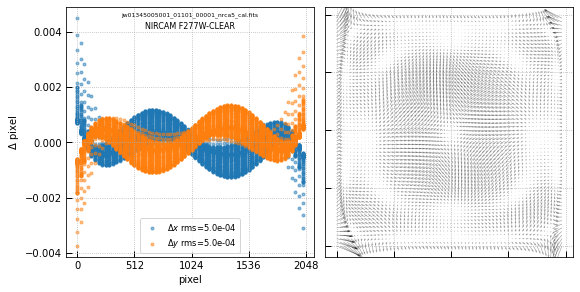

In [53]:
# Now this looks good again and the GWCS and SIP WCS are back in sync
_ = jwst_utils.compare_gwcs_sip(file, use_gwcs_func=False, save=False)

# Drizzle full mosaics

Combine all exposures in a given instrument/filter into mosaics with a common pixel grid.  

I favor the following pixel scales:

1. NIRCam/SW - 0.02" (0.031" native)
2. NIRISS, NIRCam/LW - 0.04" (0.065" native)
3. MIRI Imaging - 0.08" (0.11" native)

These grids differ by factors of two, so it is therefore possible to first define a pixel grid in the coarse 0.08" pixels and then finer grids that *exactly* subsample this 2x2.  With these 2x2 subgrids, you could, e.g., convolve a high resolution image with a PSF-matching kernel and then *block-average* 2x2 to get to the low-resolution grid.

In [57]:
os.chdir(os.path.join(HOME_PATH, 'Prep'))

# Global astrometry can fail for arbitrary WCS in simulations
# so clear out "failed" files before making mosaics
! ls *failed
if len(glob.glob('*failed')) > 0:
    ! rm *failed

ls: *failed: No such file or directory


In [60]:
mosaic_args = kwargs['mosaic_args']

mosaic_args['fill_mosaics'] = False

mosaic_args['wcs_params']['pixel_scale'] = 0.04
mosaic_args['half_optical_pixscale'] = True

# Not really ir/optical, but this comes from HST
# ir are drizzled at mosaic_args['wcs_params']['pixel_scale'], 
# optical at half that

mosaic_args['ir_filters'] = ['F277W','F356W','F444W']
mosaic_args['optical_filters'] = ['F115W','F150W','F200W']

mosaic_args['wcs_params']['pad_reference'] = 6 # small padding around edge, arcsec
kwargs['mosaic_drizzle_args']['static'] = False

if True: 
    auto_script.make_combined_mosaics(root, mosaic_args=mosaic_args, 
                                  mosaic_drizzle_args=kwargs['mosaic_drizzle_args'])

In [61]:
# Show image dimensions
!imsize -d -n 5 {root}-f*_drz_sci.fits

ceers5-f115w_drz_sci.fits 214.96718 52.91030 J2000 0.05520x0.05456 -0.0200/0.0200s/pix  9930x9818 pix
ceers5-f150w_drz_sci.fits 214.96718 52.91030 J2000 0.05520x0.05456 -0.0200/0.0200s/pix  9930x9818 pix
ceers5-f200w_drz_sci.fits 214.96718 52.91030 J2000 0.05520x0.05456 -0.0200/0.0200s/pix  9930x9818 pix
ceers5-f277w_drz_sci.fits 214.96718 52.91030 J2000 0.05520x0.05456 -0.0400/0.0400s/pix  4965x4909 pix
ceers5-f356w_drz_sci.fits 214.96718 52.91030 J2000 0.05520x0.05456 -0.0400/0.0400s/pix  4965x4909 pix
ceers5-f444w_drz_sci.fits 214.96718 52.91030 J2000 0.05520x0.05456 -0.0400/0.0400s/pix  4965x4909 pix


## RGB mosaic

Make an RGB image for display purposes.  

The script handles the fact that the SW images are 2x2 oversampled relative to LW

PATH: ./, files:['./ceers5-f115w_drz_sci.fits', './ceers5-f150w_drz_sci.fits', './ceers5-f200w_drz_sci.fits', './ceers5-f277w_drz_sci.fits', './ceers5-f356w_drz_sci.fits', './ceers5-f444w_drz_sci.fits']
# field_rgb ceers5: r f444w / g f277w / b f150w


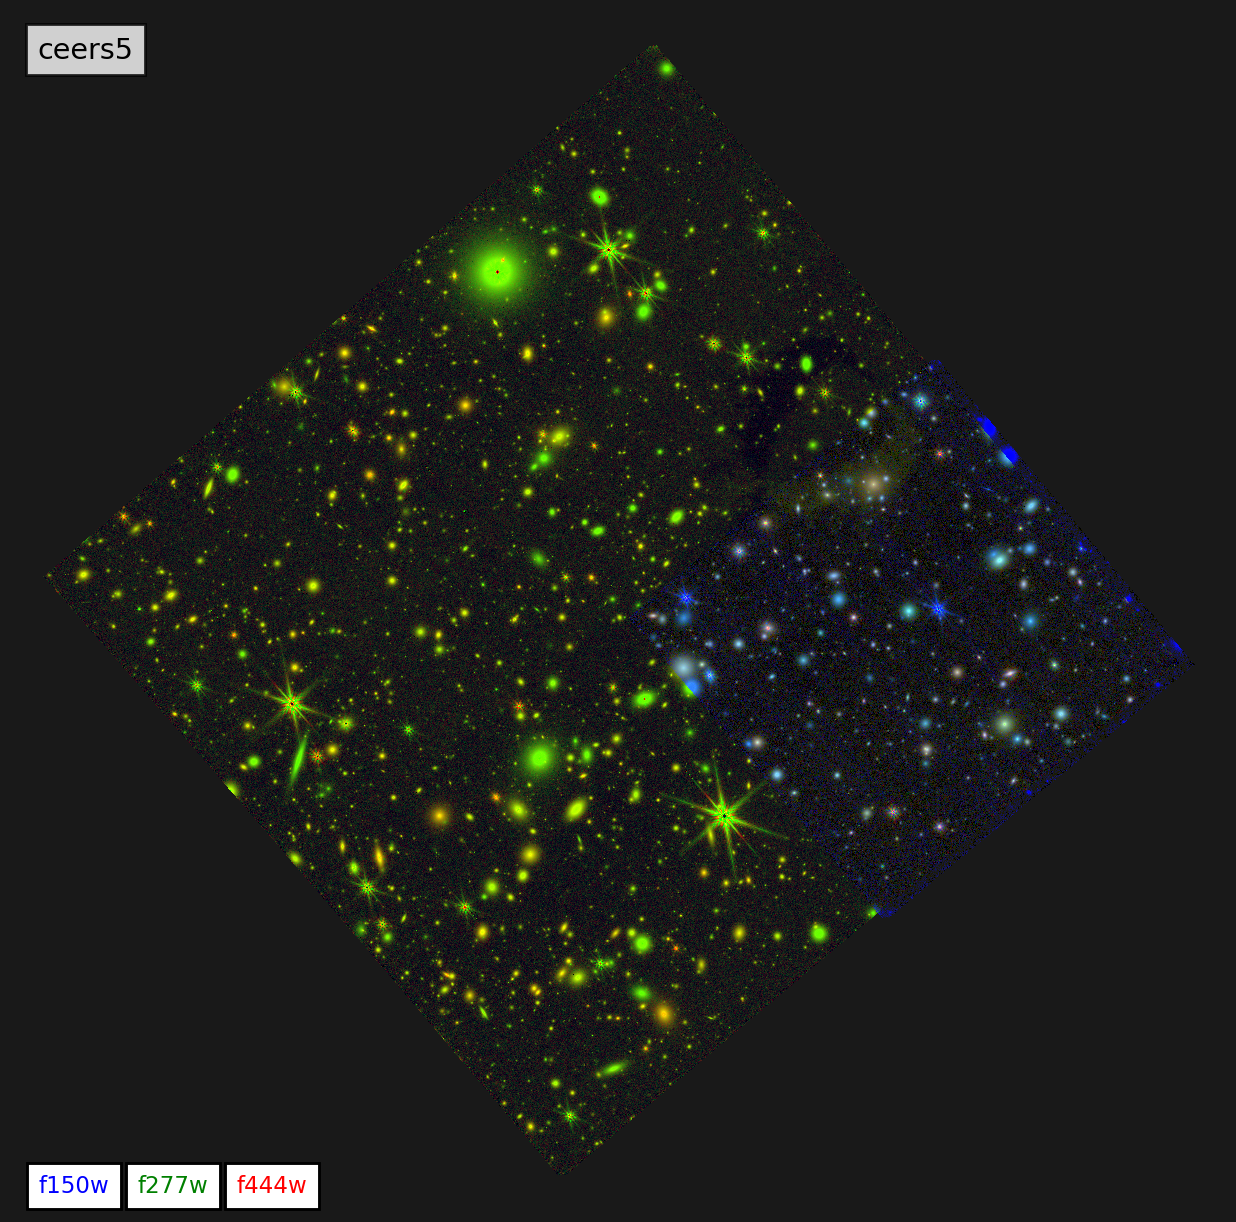

In [62]:
from IPython.display import Image

slx, sly, rgb_filts, fig = auto_script.field_rgb(root=root, scl=8, HOME_PATH=None, xsize=6,
                                                 force_rgb=['f444w','f277w','f150w'], show_ir=False, 
                                                 rgb_scl=[1.7,1.3,1], gzext='*', 
                                                 output_format='png', suffix='.field', 
                                                 full_dimensions=4 # 4x4 in png relative to f444w
                                                )  
plt.close(fig)
    
Image(filename='{0}.field.png'.format(root)) 

PATH: ./, files:['./ceers5-f115w_drz_sci.fits', './ceers5-f150w_drz_sci.fits', './ceers5-f200w_drz_sci.fits', './ceers5-f277w_drz_sci.fits', './ceers5-f356w_drz_sci.fits', './ceers5-f444w_drz_sci.fits']
# field_rgb ceers5: r f444w / g f356w / b f277w


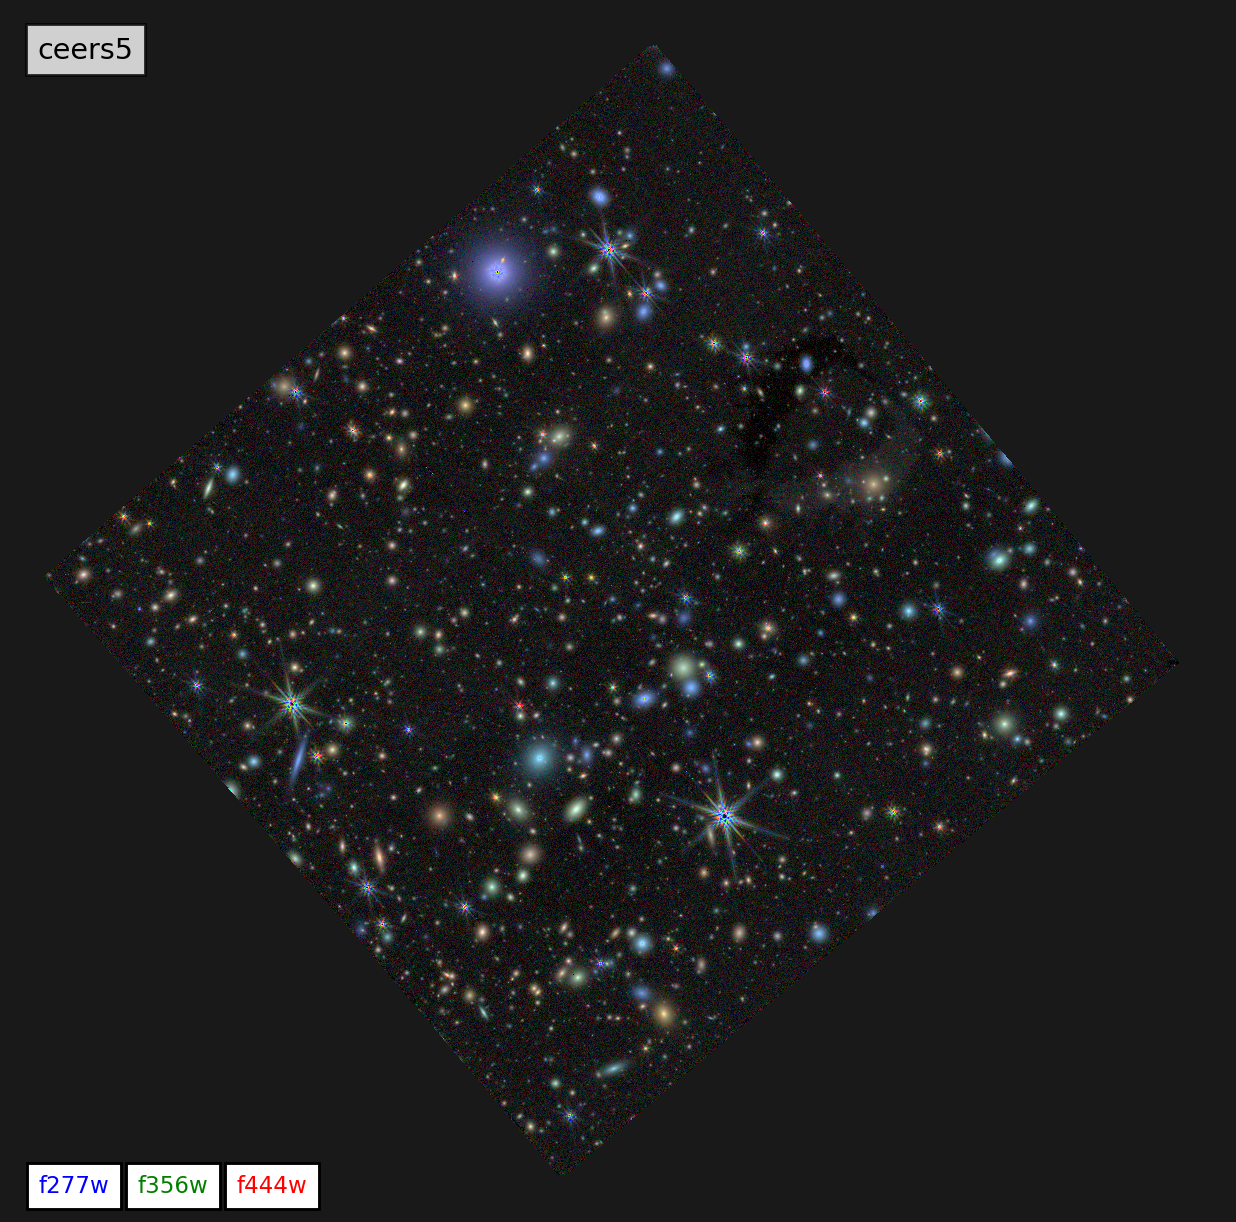

In [63]:
# LW
slx, sly, rgb_filts, fig = auto_script.field_rgb(root=root, scl=10, HOME_PATH=None, xsize=6,
                                                 force_rgb=['f444w','f356w','f277w'], show_ir=False, 
                                                 rgb_scl=[1.7,1.35,1], gzext='*', 
                                                 output_format='png', suffix='.lw', 
                                                 full_dimensions=4 # 4x4 in png relative to f444w
                                                )  
plt.close(fig)
    
Image(filename='{0}.lw.png'.format(root)) 

PATH: ./, files:['./ceers5-f115w_drz_sci.fits', './ceers5-f150w_drz_sci.fits', './ceers5-f200w_drz_sci.fits', './ceers5-f277w_drz_sci.fits', './ceers5-f356w_drz_sci.fits', './ceers5-f444w_drz_sci.fits']
# field_rgb ceers5: r f200w / g f150w / b f115w


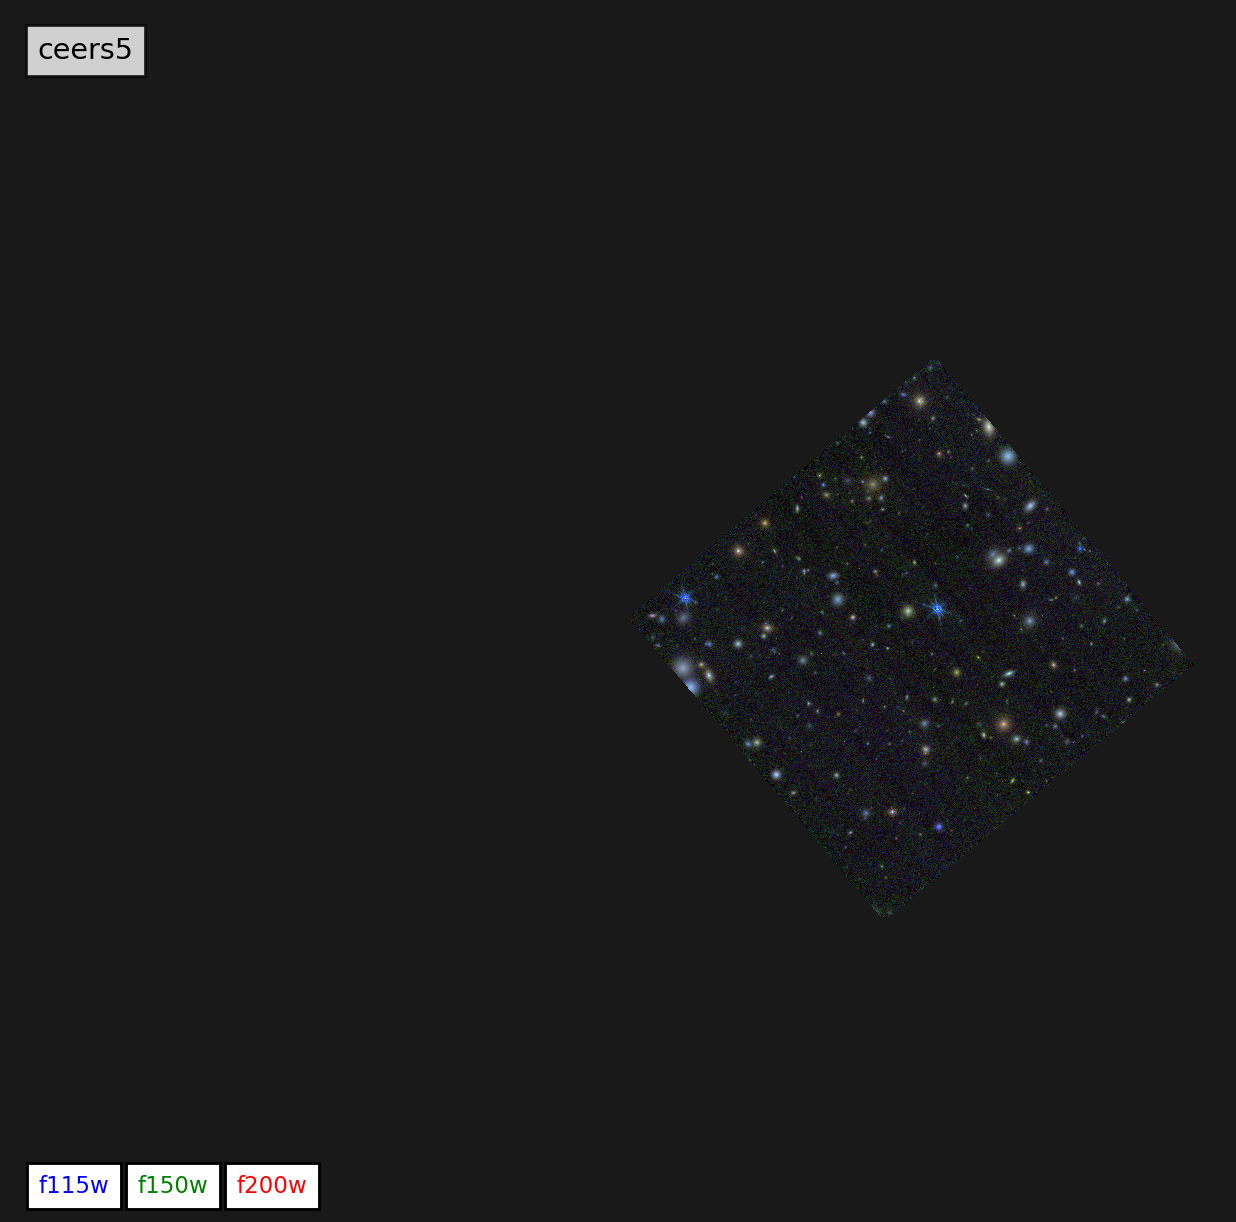

In [64]:
# SW, one detector was processed
slx, sly, rgb_filts, fig = auto_script.field_rgb(root=root, scl=10, HOME_PATH=None, xsize=6,
                                                 force_rgb=['f200w','f150w','f115w'], show_ir=False, 
                                                 rgb_scl=[1.,1.,1], gzext='*', 
                                                 output_format='png', suffix='.sw', 
                                                 full_dimensions=8 # 4x4 in png relative to f444w
                                                )  
plt.close(fig)
    
Image(filename='{0}.sw.png'.format(root)) 

# Multiwavelength catalog

Simple matched-aperture photometric catalog across filters with no PSF-matching but a bunch of apertures.  

Output units are `microJansky`

Simple aperture correction with `{band}_total_1 = {band}_flux_aper_1 * flux_auto / flux_aper_1`.

## Catalog detection image

Make a "detection" image combining filters in the low-resolution redder bands.  Here this is just F444W.

In [65]:
auto_script.make_filter_combinations(root, weight_fnu=True, min_count=1,
        filter_combinations={'lw': ['F277W','F356W','F444W']})

ceers5-f277w_drz_sci.fits f277w lw
ceers5-f356w_drz_sci.fits f356w lw
ceers5-f444w_drz_sci.fits f444w lw


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/pipeline/auto_script.py:3881: RuntimeWarning: invalid value encountered in true_divide
  sci = num[band]/den[band]


Write ceers5-lw_drz_sci.fits


## Source detection and aperture photometry

In [66]:
phot = auto_script.multiband_catalog(field_root=root, detection_filter='lw', get_all_filters=True)

# (2022-06-10 15:44:38.225)

auto_script.multiband_catalog(**{'threshold': 1.8, 'detection_background': True, 'photometry_background': True, 'get_all_filters': True, 'filters': None, 'det_err_scale': -inf, 'phot_err_scale': -inf, 'rescale_weight': True, 'run_detection': True, 'detection_filter': 'lw', 'detection_root': None, 'output_root': None, 'use_psf_filter': True, 'detection_params': {'minarea': 9, 'filter_kernel': array([[0.0049, 0.0213, 0.0513, 0.0687, 0.0513, 0.0213, 0.0049],
       [0.0213, 0.0921, 0.2211, 0.296 , 0.2211, 0.0921, 0.0213],
       [0.0513, 0.2211, 0.5307, 0.7105, 0.5307, 0.2211, 0.0513],
       [0.0687, 0.296 , 0.7105, 0.9511, 0.7105, 0.296 , 0.0687],
       [0.0513, 0.2211, 0.5307, 0.7105, 0.5307, 0.2211, 0.0513],
       [0.0213, 0.0921, 0.2211, 0.296 , 0.2211, 0.0921, 0.0213],
       [0.0049, 0.0213, 0.0513, 0.0687, 0.0513, 0.0213, 0.0049]]), 'filter_type': 'conv', 'clean': True, 'clean_param': 1, 'deblend_nthresh': 32, 'deblend_cont': 0.001}, 'phot_apertures'

/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1692: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)


# (2022-06-10 15:44:38.630)
SEP: Get background {'bw': 96.00000000000064, 'bh': 96.00000000000064, 'fw': 3, 'fh': 3}


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1767: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


SEP: err_scale=1.109
   SEP: Extract...
    Done.


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1873: RuntimeWarning: divide by zero encountered in log10
  tab['mag_iso'] = 23.9-2.5*np.log10(tab['flux_iso'])


compute_SEP_auto_params: sep version = 1.2.0
compute_SEP_auto_params: autoparams=[2.5, <Quantity 0.35 arcsec>, 2.4, 3.8]; pixel_scale=0.03999999999999973; subpix=0; flux_radii=[0.2, 0.5, 0.9]


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1908: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto'] = 23.9-2.5*np.log10(total_flux)
2022-06-10 17:44:44,511 - stpipe - WARNING - VerifyWarning: Keyword name 'FILTER_TYPE' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:44:44,514 - stpipe - WARNING - VerifyWarning: Keyword name 'THRESHOLD' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:44:44,519 - stpipe - WARNING - VerifyWarning: Keyword name 'BACK_PIXEL_SCALE' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:44:44,522 - stpipe - WARNING - VerifyWarning: Keyword name 'ERR_SCALE' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card

# SEP ceers5-lw.cat.fits: 3319 objects
f115w
# filt=f115w, need half-size segmentation image! (9818, 9930) (4909, 4965)
make_SEP_catalog: sep version = 1.2.0
# (2022-06-10 15:44:45.017)
sep: Image AB zeropoint =  27.999


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1692: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)


# (2022-06-10 15:44:47.143)
SEP: Get background {'bw': 192.000000000002, 'bh': 192.000000000002, 'fw': 3, 'fh': 3}


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1767: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


SEP: err_scale=0.888
# SEP ceers5-f115w.cat.fits: 3319 objects
f150w
# filt=f150w, need half-size segmentation image! (9818, 9930) (4909, 4965)
make_SEP_catalog: sep version = 1.2.0
# (2022-06-10 15:44:54.060)
sep: Image AB zeropoint =  27.999


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1692: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)


# (2022-06-10 15:44:55.230)
SEP: Get background {'bw': 192.000000000002, 'bh': 192.000000000002, 'fw': 3, 'fh': 3}


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1767: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


SEP: err_scale=0.805
# SEP ceers5-f150w.cat.fits: 3319 objects
f200w
# filt=f200w, need half-size segmentation image! (9818, 9930) (4909, 4965)
make_SEP_catalog: sep version = 1.2.0
# (2022-06-10 15:45:02.091)
sep: Image AB zeropoint =  27.999


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1692: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)


# (2022-06-10 15:45:03.241)
SEP: Get background {'bw': 192.000000000002, 'bh': 192.000000000002, 'fw': 3, 'fh': 3}


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1767: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


SEP: err_scale=0.745
# SEP ceers5-f200w.cat.fits: 3319 objects
f277w
make_SEP_catalog: sep version = 1.2.0
# (2022-06-10 15:45:10.239)
sep: Image AB zeropoint =  26.478


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1692: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)


# (2022-06-10 15:45:10.579)
SEP: Get background {'bw': 96.00000000000064, 'bh': 96.00000000000064, 'fw': 3, 'fh': 3}


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1767: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


SEP: err_scale=0.394
# SEP ceers5-f277w.cat.fits: 3319 objects
f356w
make_SEP_catalog: sep version = 1.2.0
# (2022-06-10 15:45:12.844)
sep: Image AB zeropoint =  26.478


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1692: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)


# (2022-06-10 15:45:13.205)
SEP: Get background {'bw': 96.00000000000064, 'bh': 96.00000000000064, 'fw': 3, 'fh': 3}


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1767: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


SEP: err_scale=0.383
# SEP ceers5-f356w.cat.fits: 3319 objects
f444w
make_SEP_catalog: sep version = 1.2.0
# (2022-06-10 15:45:15.445)
sep: Image AB zeropoint =  26.478


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1692: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)


# (2022-06-10 15:45:15.801)
SEP: Get background {'bw': 96.00000000000064, 'bh': 96.00000000000064, 'fw': 3, 'fh': 3}


/Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/grizli/prep.py:1767: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


SEP: err_scale=0.352
# SEP ceers5-f444w.cat.fits: 3319 objects


2022-06-10 17:45:18,313 - stpipe - WARNING - VerifyWarning: Keyword name 'FILTER_TYPE' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,315 - stpipe - WARNING - VerifyWarning: Keyword name 'THRESHOLD' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,321 - stpipe - WARNING - VerifyWarning: Keyword name 'BACK_PIXEL_SCALE' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,326 - stpipe - WARNING - VerifyWarning: Keyword name 'ERR_SCALE' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,332 - stpipe - WARNING - VerifyWarning: Keyword name 'F115W_VERSION' is greater than 8 characters or contains characters not allowed by the FITS standard; 

2022-06-10 17:45:18,393 - stpipe - WARNING - VerifyWarning: Keyword name 'F115W_aper_0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,397 - stpipe - WARNING - VerifyWarning: Keyword name 'F115W_asec_0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,400 - stpipe - WARNING - VerifyWarning: Keyword name 'F115W_aper_1' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,404 - stpipe - WARNING - VerifyWarning: Keyword name 'F115W_asec_1' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,408 - stpipe - WARNING - VerifyWarning: Keyword name 'F115W_aper_2' is greater than 8 characters or contains characters not allowed by the FITS standard

2022-06-10 17:45:18,473 - stpipe - WARNING - VerifyWarning: Keyword name 'F150W_GET_BACK' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,477 - stpipe - WARNING - VerifyWarning: Keyword name 'F150W_BACK_BW' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,480 - stpipe - WARNING - VerifyWarning: Keyword name 'F150W_BACK_BH' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,484 - stpipe - WARNING - VerifyWarning: Keyword name 'F150W_BACK_FW' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,487 - stpipe - WARNING - VerifyWarning: Keyword name 'F150W_BACK_FH' is greater than 8 characters or contains characters not allowed by the FITS st

2022-06-10 17:45:18,553 - stpipe - WARNING - VerifyWarning: Keyword name 'F150W_asec_5' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,557 - stpipe - WARNING - VerifyWarning: Keyword name 'F150W_aper_6' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,561 - stpipe - WARNING - VerifyWarning: Keyword name 'F150W_asec_6' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,565 - stpipe - WARNING - VerifyWarning: Keyword name 'F200W_VERSION' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,569 - stpipe - WARNING - VerifyWarning: Keyword name 'F200W_PLAM' is greater than 8 characters or contains characters not allowed by the FITS standard;

2022-06-10 17:45:18,635 - stpipe - WARNING - VerifyWarning: Keyword name 'F200W_asec_0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,638 - stpipe - WARNING - VerifyWarning: Keyword name 'F200W_aper_1' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,642 - stpipe - WARNING - VerifyWarning: Keyword name 'F200W_asec_1' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,646 - stpipe - WARNING - VerifyWarning: Keyword name 'F200W_aper_2' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,649 - stpipe - WARNING - VerifyWarning: Keyword name 'F200W_asec_2' is greater than 8 characters or contains characters not allowed by the FITS standard

2022-06-10 17:45:18,716 - stpipe - WARNING - VerifyWarning: Keyword name 'F277W_BACK_BW' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,719 - stpipe - WARNING - VerifyWarning: Keyword name 'F277W_BACK_BH' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,723 - stpipe - WARNING - VerifyWarning: Keyword name 'F277W_BACK_FW' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,727 - stpipe - WARNING - VerifyWarning: Keyword name 'F277W_BACK_FH' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,731 - stpipe - WARNING - VerifyWarning: Keyword name 'F277W_BACK_PIXEL_SCALE' is greater than 8 characters or contains characters not allowed by the

2022-06-10 17:45:18,796 - stpipe - WARNING - VerifyWarning: Keyword name 'F277W_aper_6' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,799 - stpipe - WARNING - VerifyWarning: Keyword name 'F277W_asec_6' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,803 - stpipe - WARNING - VerifyWarning: Keyword name 'F356W_VERSION' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,808 - stpipe - WARNING - VerifyWarning: Keyword name 'F356W_PLAM' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,812 - stpipe - WARNING - VerifyWarning: Keyword name 'F356W_FNU' is greater than 8 characters or contains characters not allowed by the FITS standard; a 

2022-06-10 17:45:18,876 - stpipe - WARNING - VerifyWarning: Keyword name 'F356W_aper_1' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,880 - stpipe - WARNING - VerifyWarning: Keyword name 'F356W_asec_1' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,884 - stpipe - WARNING - VerifyWarning: Keyword name 'F356W_aper_2' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,888 - stpipe - WARNING - VerifyWarning: Keyword name 'F356W_asec_2' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,892 - stpipe - WARNING - VerifyWarning: Keyword name 'F356W_aper_3' is greater than 8 characters or contains characters not allowed by the FITS standard

2022-06-10 17:45:18,957 - stpipe - WARNING - VerifyWarning: Keyword name 'F444W_BACK_BH' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,961 - stpipe - WARNING - VerifyWarning: Keyword name 'F444W_BACK_FW' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,965 - stpipe - WARNING - VerifyWarning: Keyword name 'F444W_BACK_FH' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,968 - stpipe - WARNING - VerifyWarning: Keyword name 'F444W_BACK_PIXEL_SCALE' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:18,972 - stpipe - WARNING - VerifyWarning: Keyword name 'F444W_ERR_SCALE' is greater than 8 characters or contains characters not allowed by t

2022-06-10 17:45:19,040 - stpipe - WARNING - VerifyWarning: Keyword name 'F444W_asec_6' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2022-06-10 17:45:19,065 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


In [67]:
phot.info()

<GTable length=3319>
        name          dtype  unit n_bad
-------------------- ------- ---- -----
                  id   int32          0
              thresh float64          0
                npix   int64          0
               tnpix   int64          0
                xmin   int64          0
                xmax   int64          0
                ymin   int64          0
                ymax   int64          0
                   x float64          0
                   y float64          0
            x2_image float64          0
            y2_image float64          0
            xy_image float64          0
               errx2 float64          0
               erry2 float64          0
               errxy float64          0
             a_image float64          0
             b_image float64          0
         theta_image float64          0
           cxx_image float64          0
           cyy_image float64          0
           cxy_image float64          0
               cflu

In [68]:
# Show full directory contents
! ls -1 *

astrodrizzle.log
ceers5-01345-005-131.0-f115w-clear.cat.fits
ceers5-01345-005-131.0-f115w-clear.cat.radec
ceers5-01345-005-131.0-f115w-clear.cat.reg
ceers5-01345-005-131.0-f115w-clear_drz_sci.fits
ceers5-01345-005-131.0-f115w-clear_shifts.log
ceers5-01345-005-131.0-f115w-clear_wcs.fits
ceers5-01345-005-131.0-f115w-clear_wcs.log
ceers5-01345-005-131.0-f115w-clear_wcs.png
ceers5-01345-005-131.0-f150w-clear.cat.fits
ceers5-01345-005-131.0-f150w-clear.cat.radec
ceers5-01345-005-131.0-f150w-clear.cat.reg
ceers5-01345-005-131.0-f150w-clear_drz_sci.fits
ceers5-01345-005-131.0-f150w-clear_shifts.log
ceers5-01345-005-131.0-f150w-clear_wcs.fits
ceers5-01345-005-131.0-f150w-clear_wcs.log
ceers5-01345-005-131.0-f150w-clear_wcs.png
ceers5-01345-005-131.0-f200w-clear.cat.fits
ceers5-01345-005-131.0-f200w-clear.cat.radec
ceers5-01345-005-131.0-f200w-clear.cat.reg
ceers5-01345-005-131.0-f200w-clear_drz_sci.fits
ceers5-01345-005-131.0-f200w-clear_shifts.log
ceers5-01345-005-131.0-f200w-clear_wcs.fits
c

## Compare to input photometry from the simulation

In [69]:
sam_input = '../CEERS_SAM_input.fits'
if not os.path.exists(sam_input):
    print(f'fetch {sam_input} catalog')
    os.system(f'wget "https://web.corral.tacc.utexas.edu/ceersdata/SDR1/catalogs/CEERS_SAM_input.fits" -O {sam_input}')

inp = utils.read_catalog(sam_input)

# Apply offsets we made earlier to the sam catalog so that we can match to 
# our new catalog based on position
inp['ra'] += dx_cat/3600/np.cos(inp['dec']/180*np.pi)
inp['dec'] += dy_cat/3600.

print(sam_input, len(inp))

../CEERS_SAM_input.fits 1472791


### Completeness

In [70]:
# All SAM sources that *could* be in phot
for v in visits:
    if 'f444w' in v['product']:
        break

sr = utils.SRegion(v['footprint'])
pts = np.array([inp['ra'], inp['dec']]).T
in_footprint = sr.path[0].contains_points(pts)
in_footprint.sum()

inp_parent = inp[in_footprint]

/var/folders/tv/ycbhjzmd34j5ntfdldnxf5xr0000gn/T/ipykernel_86981/2863019307.py:4: RuntimeWarning: invalid value encountered in log10
  f444w_mag = (23.9-2.5*np.log10(phot[f'f444w_flux_aper_{aper_ix}']*apcorr))
/var/folders/tv/ycbhjzmd34j5ntfdldnxf5xr0000gn/T/ipykernel_86981/2863019307.py:16: RuntimeWarning: divide by zero encountered in true_divide
  axes[1].step(_hdet[1][1:], _hdet[0]/_hinp[0], color='k')
/var/folders/tv/ycbhjzmd34j5ntfdldnxf5xr0000gn/T/ipykernel_86981/2863019307.py:16: RuntimeWarning: invalid value encountered in true_divide
  axes[1].step(_hdet[1][1:], _hdet[0]/_hinp[0], color='k')


Text(0.5, 0, 'F444W mag, AB')

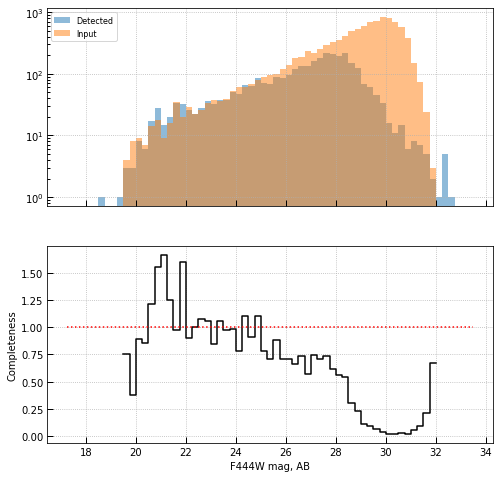

In [71]:
# Completeness
aper_ix = 2
apcorr = phot['flux_auto'] / phot[f'flux_aper_{aper_ix}']
f444w_mag = (23.9-2.5*np.log10(phot[f'f444w_flux_aper_{aper_ix}']*apcorr))

f444w_input = inp_parent[f'NIRCam_F444W']

bins = np.arange(18, 33, 0.25)
fig, axes = plt.subplots(2,1,sharex=True, figsize=(8,8))

_hdet = axes[0].hist(f444w_mag, bins=bins, alpha=0.5, label='Detected', log=True)
_hinp = axes[0].hist(f444w_input, bins=bins, alpha=0.5, label='Input')
axes[0].grid()
axes[0].legend(loc='upper left', fontsize=8)

axes[1].step(_hdet[1][1:], _hdet[0]/_hinp[0], color='k')
axes[1].grid()
axes[1].set_ylabel('Completeness')
axes[1].hlines(1, *axes[1].get_xlim(), color='r', linestyle=':')

axes[1].set_xlabel('F444W mag, AB')


Text(0, 0.5, 'dDec offset, arcsec')

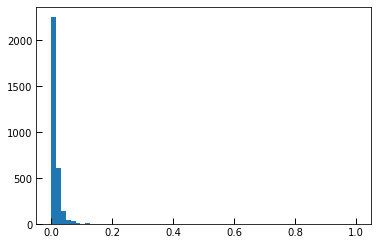

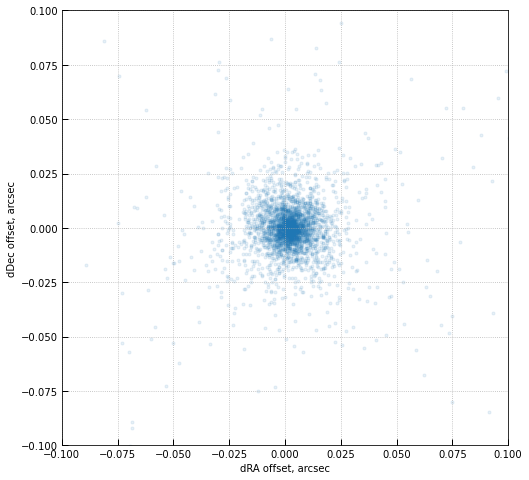

In [72]:
# Close matches to compare photometry
idx, dr, dx, dy = inp.match_to_catalog_sky(phot, get_2d_offset=True)

_h = plt.hist(dr.value, bins=np.linspace(0,1,64), log=False)

hasm = dr.value < 0.05

inp = inp[idx][hasm]
ph = phot[hasm]

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(dx.value, dy.value, alpha=0.1)
ax.grid()
ax.set_xlim(-0.1,0.1)
ax.set_ylim(-0.1,0.1)
ax.set_xlabel('dRA offset, arcsec')
ax.set_ylabel('dDec offset, arcsec')

Aperture #2, D=0.7"


/var/folders/tv/ycbhjzmd34j5ntfdldnxf5xr0000gn/T/ipykernel_86981/2005243459.py:14: RuntimeWarning: invalid value encountered in log10
  ph_mag = (23.9-2.5*np.log10(ph[f'{b.lower()}_flux_aper_{aper_ix}']*apcorr))


(19.0, 28.0)

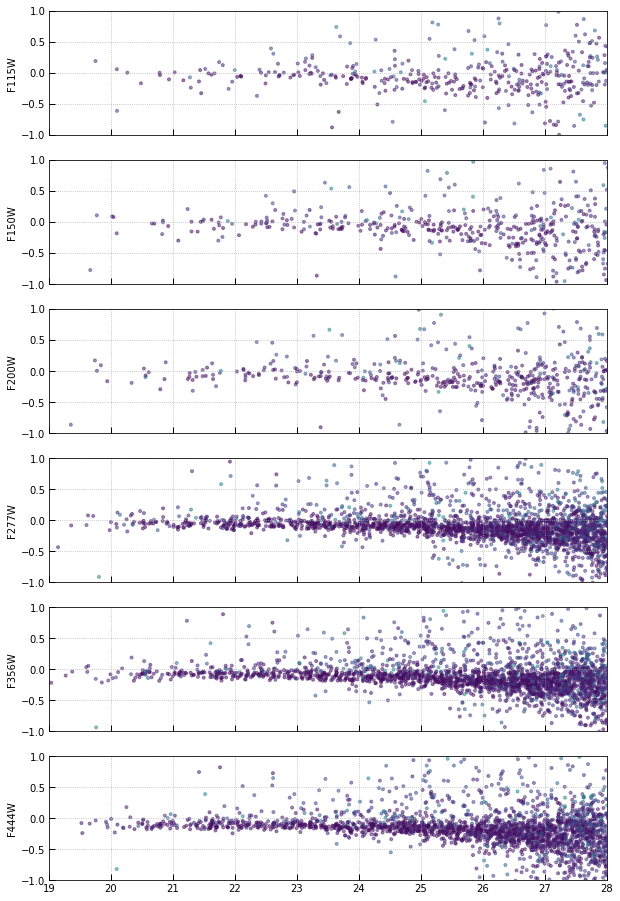

In [73]:
# Compare the magnitudes in each filter
fig, axes = plt.subplots(6,1, sharex=True, sharey=True, figsize=(10,16))

aper_ix = 2
aper_d = ph.meta[f'asec_{aper_ix}'][0]
                   
print(f"Aperture #{aper_ix}, D={aper_d:.1f}\"")
                   
for i, b in enumerate(['F115W','F150W','F200W','F277W','F356W','F444W']):
    
    # Doesn't account for flux outside the auto aperture for a given band
    apcorr = ph['flux_auto'] / ph[f'flux_aper_{aper_ix}']
    
    ph_mag = (23.9-2.5*np.log10(ph[f'{b.lower()}_flux_aper_{aper_ix}']*apcorr))
                   
    axes[i].scatter(inp[f'NIRCam_{b}'],
                    inp[f'NIRCam_{b}'] - ph_mag, 
                    c=dr[hasm].value,
                    vmin=0, vmax=0.1,
                    alpha=0.5)
                   
    axes[i].set_ylabel(b)
    axes[i].grid()
    
axes[i].set_ylim(-1,1)
axes[i].set_xlim(19, 28)


# TBD

- Run the catalog through eazy-py??
- PSF generation
  - PSF matching for photometry
- Full manual specification of the output WCS of the drizzle combinations?